In [1]:
!pip install git+https://github.com/jkirkby3/pymle.git

  Cloning https://github.com/jkirkby3/pymle.git to c:\users\vlada\appdata\local\temp\pip-req-build-_noeetnh
  Resolved https://github.com/jkirkby3/pymle.git to commit 412f74f5201782686f13ed2c60acd07b740c42e8
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/jkirkby3/pymle.git 'C:\Users\Vlada\AppData\Local\Temp\pip-req-build-_noeetnh'

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np, scipy.stats as st

from scipy.stats import norm
from tqdm import tqdm
from pymle.models import CIR, CKLS, OrnsteinUhlenbeck
from pymle.sim.Simulator1D import Simulator1D
from pymle.core.TransitionDensity import ExactDensity, KesslerDensity, OzakiDensity, EulerDensity, ShojiOzakiDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE

In [3]:
# Define auxiliary function to find minimal value
def argmin(iterable):
    return min(enumerate(iterable), key=lambda x: x[1])[0]

Task 1. Constant Maturity Interest Rates. Fit models (CEV, CIR, OU, CKLS) to a sample of historical interest rates over the period Jan 1, 1962 to till now. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using MLE approach.

The estimated parameters display in a table for each method. Calculate the AIC and select the best model. Compare your results with paper by Kirkby et. al (https://arxiv.org/abs/2108.12649) where the period from Jan 1, 1962 to April 8, 2021 (14,801 daily observations).

Dataset: Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (DGS10),
https://fred.stlouisfed.org/series/DGS10  

In [4]:
# Read data and preprocessing it
df_IR = pd.read_csv('DGS10.csv')
df_IR = df_IR[df_IR['DGS10'] != '.']

# Make valid numerical sample
sample = df_IR['DGS10'].values
sample = [float(sample[i]) for i in range(len(sample))]
sample = np.array(sample)

Task. Download the DGS10 dataset directlly from https://fred.stlouisfed.org/series/DGS10 .

Hint.

Use  
`from pymle.data.loader import load_10yr_CMrate`

In [5]:
# your code
from pymle.data.loader import load_10yr_CMrate

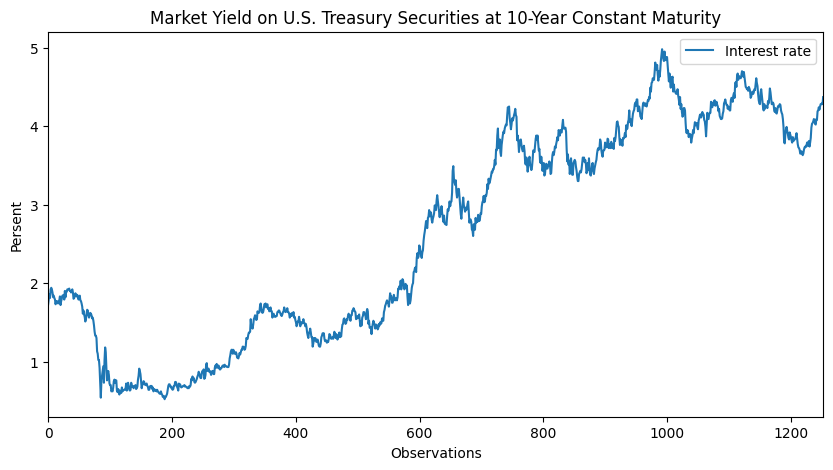

In [6]:
# Plot
figure, ax = plt.subplots(figsize=(10,5))
ax.plot(np.linspace(0, len(sample), len(sample)),sample, label='Interest rate')
plt.title('Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity')
plt.xlim(0, len(sample))
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.show()

### Task. Change the X marks to dates.

In [7]:
df_IR['DATE'] = pd.to_datetime(df_IR['DATE'], errors='coerce')
df_IR = df_IR.dropna(subset=['DATE'])
data = df_IR['DATE']

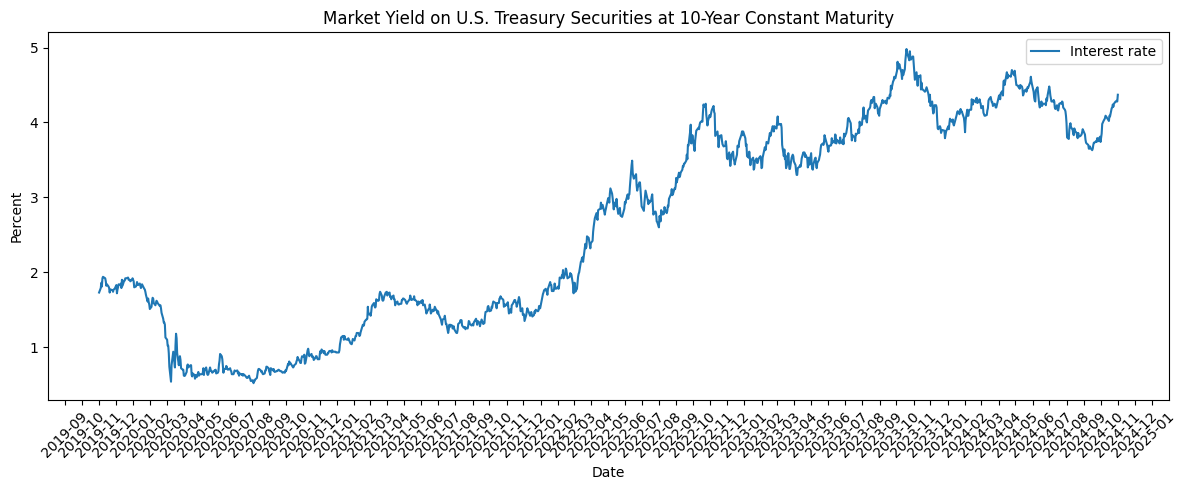

In [8]:
import matplotlib.dates as mdates

figure, ax = plt.subplots(figsize=(12, 5))

ax.plot(data, sample, label='Interest rate')

ax.xaxis.set_major_locator(mdates.MonthLocator())  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)

plt.title('Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity')
plt.ylabel('Percent')
plt.xlabel('Date')

plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# Import models for fitting:
from pymle.models import BrownianMotion, CEV, CIR,\
                         CKLS, GeometricBM, IGBM, \
                         OrnsteinUhlenbeck

In [10]:
# a) fit using Kessler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252

# Estimate max likelyhood, using KesslerDensity
kessler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
kessler_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -9710.518416773059
`xtol` termination condition is satisfied.
Number of iterations: 35, function evaluations: 84, CG iterations: 55, optimality: 4.20e-04, constraint violation: 0.00e+00, execution time: 0.056 s.
Final Params: [0.53176852 0.99395277]
Final Likelihood: 1691.1536008519797
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.47065226873


C:\Users\Vlada\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 133, function evaluations: 735, CG iterations: 467, optimality: 3.21e+00, constraint violation: 0.00e+00, execution time: 0.37 s.
Final Params: [0.03511418 0.14073404 0.81453091 0.22595538]
Final Likelihood: 1715.5682778438122
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2715.090860516785
`xtol` termination condition is satisfied.
Number of iterations: 44, function evaluations: 232, CG iterations: 84, optimality: 3.36e+00, constraint violation: 0.00e+00, execution time: 0.085 s.
Final Params: [0.03246559 0.16653868 0.68411695]
Final Likelihood: 1670.3581084168954
Initial Params: [0.01, 0.2]
Initial Likelihood: -955.3444040321195
`xtol` termination condition is satisfied.
Number of iterations: 35, function evaluations: 75, CG iterations: 48, optimality: 4.89e+00, constraint violation: 0.00e+00, execution time: 0.041 s.
Final Params: [0.36504571 0.59271222]
Final Likelihood: 1357.2471566812435
Initial Params: [0.0

In [11]:
best_ind = argmin(kessler_est)
print("AIC values for Kessler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     kessler_est[0], model_name[0], kessler_params[0],\
     kessler_est[1], model_name[1], kessler_params[1],\
     kessler_est[2], model_name[2], kessler_params[2],\
     kessler_est[3], model_name[3], kessler_params[3],\
     kessler_est[4], model_name[4], kessler_params[4],\
     kessler_est[5], model_name[5], kessler_params[5],\
     kessler_est[6], model_name[6], kessler_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], kessler_params[best_ind]))

AIC values for Kessler estimation:
       -3378.307 - BrownianMotion model with params [0.53176852 0.99395277],
       -3423.137 - CEV model with params [0.03511418 0.14073404 0.81453091 0.22595538],
       -3334.716 - CIR model with params [0.03246559 0.16653868 0.68411695],
       -2710.494 - GeometricBM model with params [0.36504571 0.59271222],
       -2716.890 - IGBM model with params [0.71741706 2.61926512 0.59116981],
       -3376.488 - OrnsteinUhlenbeck model with params [0.13888564 6.43707418 0.99388081],
       -3394.324 - CKLS model with params [0.30858568 0.18139421 0.71751458 0.38328909],
       
The best model is CEV     with param [0.03511418 0.14073404 0.81453091 0.22595538]


In [12]:
# b) fit using Shoji-Ozaki method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
shoji_ozaki_est      = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
shoji_ozaki_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -9710.518416772424
`xtol` termination condition is satisfied.
Number of iterations: 41, function evaluations: 81, CG iterations: 59, optimality: 1.01e-05, constraint violation: 0.00e+00, execution time: 0.055 s.
Final Params: [0.53179876 0.99395295]
Final Likelihood: 1691.153600854306
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.5899890722
`xtol` termination condition is satisfied.
Number of iterations: 81, function evaluations: 395, CG iterations: 255, optimality: 1.03e-02, constraint violation: 0.00e+00, execution time:  0.2 s.
Final Params: [0.12397888 6.6997523  0.81926789 0.22232551]
Final Likelihood: 1716.715784468694
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2717.131652681157
`xtol` termination condition is satisfied.
Number of iterations: 58, function evaluations: 240, CG iterations: 110, optimality: 3.93e-02, constraint violation: 0.00e+00, execution time: 0.11 s.
Final Params: [0.11131574 7.460

In [13]:
best_ind = argmin(shoji_ozaki_est)
print("AIC values for Shoji-Ozaki estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     shoji_ozaki_est[0], model_name[0], shoji_ozaki_params[0],\
     shoji_ozaki_est[1], model_name[1], shoji_ozaki_params[1],\
     shoji_ozaki_est[2], model_name[2], shoji_ozaki_params[2],\
     shoji_ozaki_est[3], model_name[3], shoji_ozaki_params[3],\
     shoji_ozaki_est[4], model_name[4], shoji_ozaki_params[4],\
     shoji_ozaki_est[5], model_name[5], shoji_ozaki_params[5],\
     shoji_ozaki_est[6], model_name[6], shoji_ozaki_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], shoji_ozaki_params[best_ind]))

AIC values for Shoji-Ozaki estimation:
       -3378.307 - BrownianMotion model with params [0.53179876 0.99395295],
       -3425.432 - CEV model with params [0.12397888 6.6997523  0.81926789 0.22232551],
       -3337.463 - CIR model with params [0.11131574 7.46068248 0.68414493],
       -2712.471 - GeometricBM model with params [0.22559931 0.59515403],
       -2714.791 - IGBM model with params [0.16912903 6.50936932 0.59458353],
       -3374.106 - OrnsteinUhlenbeck model with params [0.06321414 0.24797587 0.99479873],
       -3425.240 - CKLS model with params [0.472788   0.04440712 0.8189581  0.2224848 ],
       
The best model is CEV     with param [0.12397888 6.6997523  0.81926789 0.22232551]


In [14]:
# c) fit using Euler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
eu_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -9710.518416772424
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 78, CG iterations: 58, optimality: 1.06e-05, constraint violation: 0.00e+00, execution time: 0.053 s.
Final Params: [0.53180469 0.99395295]
Final Likelihood: 1691.1536008542116
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`xtol` termination condition is satisfied.
Number of iterations: 62, function evaluations: 295, CG iterations: 181, optimality: 8.33e-03, constraint violation: 0.00e+00, execution time: 0.11 s.
Final Params: [0.08794999 8.67455022 0.81906432 0.22233633]
Final Likelihood: 1716.7194252289776
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2716.9221975120217
`xtol` termination condition is satisfied.
Number of iterations: 49, function evaluations: 200, CG iterations: 102, optimality: 8.03e-03, constraint violation: 0.00e+00, execution time: 0.069 s.
Final Params: [0.08360836 

In [15]:
best_ind = argmin(euler_est)
print("AIC values for Euler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     euler_est[0], model_name[0], eu_params[0],\
     euler_est[1], model_name[1], eu_params[1],\
     euler_est[2], model_name[2], eu_params[2],\
     euler_est[3], model_name[3], eu_params[3],\
     euler_est[4], model_name[4], eu_params[4],\
     euler_est[5], model_name[5], eu_params[5],\
     euler_est[6], model_name[6], eu_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], eu_params[best_ind]))

AIC values for Euler estimation:
       -3378.307 - BrownianMotion model with params [0.53180469 0.99395295],
       -3425.439 - CEV model with params [0.08794999 8.67455022 0.81906432 0.22233633],
       -3337.455 - CIR model with params [0.08360836 9.34024448 0.68399866],
       -2712.728 - GeometricBM model with params [0.36104907 0.59536034],
       -2715.079 - IGBM model with params [0.41064638 3.27668097 0.59432587],
       -3376.488 - OrnsteinUhlenbeck model with params [0.13895318 6.43415745 0.99388112],
       -3425.326 - CKLS model with params [0.543029   0.010006   0.8190517  0.22240482],
       
The best model is CEV     with param [0.08794999 8.67455022 0.81906432 0.22233633]


In [16]:
print("For the best model {}\n \
    params are:\n \
    {},\n \
    {},\n \
    {}".format(
    model_name[best_ind],\
    kessler_params[best_ind],\
    shoji_ozaki_params[best_ind],\
    eu_params[best_ind]))

For the best model CEV
     params are:
     [0.03511418 0.14073404 0.81453091 0.22595538],
     [0.12397888 6.6997523  0.81926789 0.22232551],
     [0.08794999 8.67455022 0.81906432 0.22233633]


In [17]:
shoji_ozaki_p = [0.01190742, 0.6541825, 0.57703004, 0.32514395]
kessler_p     = [0.02011782, 0.13874663, 0.567096, 0.33594728]
euler_p       = [0.06504598, 5.87897445, 0.57674668, 0.32538039]

### Task: Rewrite code and pass estimated parameters programmatically.

In [18]:
from tabulate import tabulate
import numpy as np

class ModelEstimator:
    def __init__(self, sample, models, model_names, param_bounds, param_guesses, dt=1./252):
        self.sample = sample
        self.models = models
        self.model_names = model_names
        self.param_bounds = param_bounds
        self.param_guesses = param_guesses
        self.dt = dt
        self.results = {'Kessler': {}, 'Shoji-Ozaki': {}, 'Euler': {}}

    def estimate_params(self, method, model, param_bounds, param_guess):
        """
        Estimate parameters using the given method and model.
        """
        if method == 'Kessler':
            density = KesslerDensity(model)
        elif method == 'Shoji-Ozaki':
            density = ShojiOzakiDensity(model)
        elif method == 'Euler':
            density = EulerDensity(model)
        else:
            raise ValueError(f"Unknown method {method}")
        
        estimator = AnalyticalMLE(self.sample, param_bounds, self.dt, density=density)
        result = estimator.estimate_params(param_guess)
        return result.aic, result.params

    def fit_models(self):
        """
        Estimate parameters for each model using each method.
        """
        for method in self.results.keys():
            for i, model in enumerate(self.models):
                aic, params = self.estimate_params(method, model, self.param_bounds[i], self.param_guesses[i])
                self.results[method][self.model_names[i]] = {'aic': aic, 'params': params}

    def print_aic_results(self):
        """
        Print AIC results for all models and methods.
        """
        for method, data in self.results.items():
            print(f"\n{'='*40}")
            print(f"AIC values for {method} estimation:")
            print(f"{'Model':<20} {'AIC':<10} {'Parameters'}")
            print("-" * 40)
            for model in self.model_names:
                aic = data[model]['aic']
                params = data[model]['params']
                print(f"{model:<20} {aic:<10.3f} {params}")
            print("="*40)

    def print_best_model(self):
        """
        Print the best model for each method (based on the lowest AIC).
        """
        for method, data in self.results.items():
            best_model = min(data, key=lambda x: data[x]['aic'])  # Model with the lowest AIC
            best_params = data[best_model]['params']
            print(f"\n{'='*40}")
            print(f"Best model for {method} estimation:")
            print(f"{'Model':<20} {best_model}")
            print(f"{'Parameters':<20} {best_params}")
            print("="*40)

    def print_combined_results(self):
        """
        Print the combined best model results across all methods.
        """
        best_models = {
            'Kessler': min(self.results['Kessler'], key=lambda x: self.results['Kessler'][x]['aic']),
            'Shoji-Ozaki': min(self.results['Shoji-Ozaki'], key=lambda x: self.results['Shoji-Ozaki'][x]['aic']),
            'Euler': min(self.results['Euler'], key=lambda x: self.results['Euler'][x]['aic'])
        }

        print(f"\n{'='*40}")
        print("Combined Best Models Across All Methods:")
        print(f"{'Method':<15} {'Best Model':<20} {'Parameters'}")
        print("-" * 40)
        for method in ['Kessler', 'Shoji-Ozaki', 'Euler']:
            best_model = best_models[method]
            best_params = self.results[method][best_model]['params']
            print(f"{method:<15} {best_model:<20} {best_params}")
        print("="*40)


In [19]:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), IGBM(), OrnsteinUhlenbeck(), CKLS()]

param_bounds = [
    [(0.01, 10), (0.01, 2)],                         # Brownian Motion
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # CIR
    [(0.01, 10), (0.01, 2)],                         # GBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # IGBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # OU
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
]

param_guess = [
    [0.01, 0.2],                                     # Brownian Motion
    [0.01, 0.01, 0.01, 0.2],                         # CEV
    [0.01, 0.01, 0.2],                               # CIR
    [0.01, 0.2],                                     # GBM
    [0.01, 0.01, 0.2],                               # IGBM
    [0.01, 0.01, 0.2],                               # OU
    [0.01, 0.01, 0.01, 0.2]                          # CKLS
]


# Initialize the ModelEstimator
estimator = ModelEstimator(sample, model, model_name, param_bounds, param_guess)

# Fit the models and print results
estimator.fit_models()
estimator.print_aic_results()
estimator.print_best_model()
estimator.print_combined_results()


Initial Params: [0.01, 0.2]
Initial Likelihood: -9710.518416773059
`xtol` termination condition is satisfied.
Number of iterations: 35, function evaluations: 84, CG iterations: 55, optimality: 4.20e-04, constraint violation: 0.00e+00, execution time: 0.042 s.
Final Params: [0.53176852 0.99395277]
Final Likelihood: 1691.1536008519797
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.47065226873
`xtol` termination condition is satisfied.
Number of iterations: 133, function evaluations: 735, CG iterations: 467, optimality: 3.21e+00, constraint violation: 0.00e+00, execution time: 0.36 s.
Final Params: [0.03511418 0.14073404 0.81453091 0.22595538]
Final Likelihood: 1715.5682778438122
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2715.090860516785
`xtol` termination condition is satisfied.
Number of iterations: 44, function evaluations: 232, CG iterations: 84, optimality: 3.36e+00, constraint violation: 0.00e+00, execution time: 0.072 s.
Final Params: [0.03246559 0

In [20]:
# Generate a CEV process with estimated parameters
# Define auxiliary functions:
def Wiener_proc(N, T):
    W = np.zeros(N)
    delta = T / N
    sqrt_delta = np.sqrt(delta)
    for i in range (1, N):
        W[i] += W[i-1] + rnd.normal(0, sqrt_delta)
    return W

#  CEV process:
def CEV_pr(S, kappa, mu, sigma, gamma, dt, dW):
    dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW
    return dS

In [21]:
cW = [sample[i] - sample[i-1] for i in range(1, len(sample))]

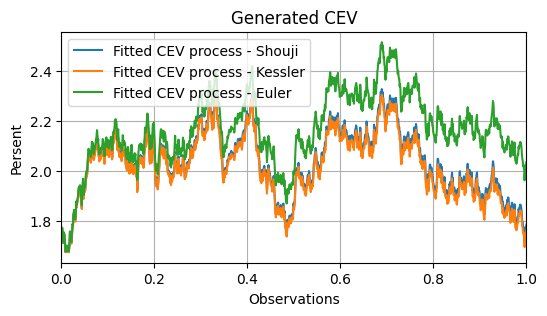

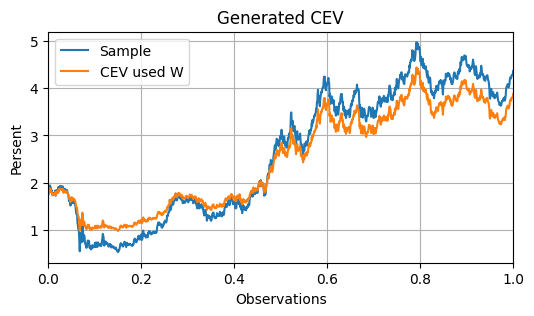

In [22]:
T = 1
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cev_s, cev_k, cev_e = np.zeros(N), np.zeros(N), np.zeros(N)
cev_s[0], cev_k[0], cev_e[0] = S0, S0, S0
ecev = np.zeros(N)
ecev[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cev_s[i] = cev_s[i-1] + CEV_pr(cev_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW)
    cev_k[i] = cev_k[i-1] + CEV_pr(cev_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW)
    cev_e[i] = cev_e[i-1] + CEV_pr(cev_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW)
    ecev[i] = ecev[i-1] + CEV_pr(ecev[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, cW[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, cev_s, label="Fitted CEV process - Shouji")
plt.plot(time_line, cev_k, label="Fitted CEV process - Kessler")
plt.plot(time_line, cev_e, label="Fitted CEV process - Euler")
plt.title("Generated CEV")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecev, label='CEV used W')
plt.title("Generated CEV")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

### Task. Generate a CKLS process with estimated parameters.

In [23]:
def CKLS_process(S, kappa, mu, sigma, gamma, dt, dW):
    S_non_neg = np.maximum(S, 1e-6)  
    dS = kappa * (mu - S) * dt + sigma * (S_non_neg**gamma) * dW
    return dS

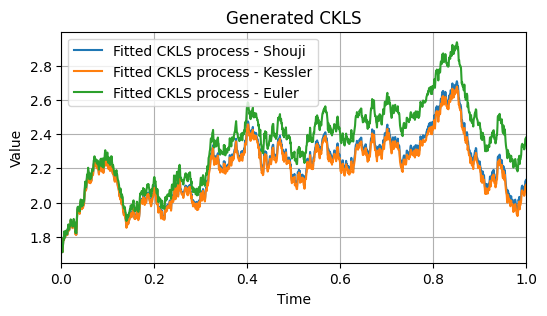

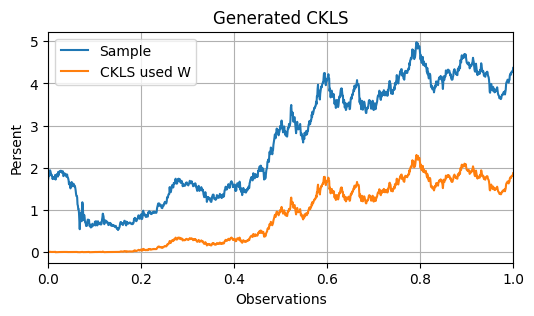

In [24]:
T = 1
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
ckls_s, ckls_k, ckls_e = np.zeros(N), np.zeros(N), np.zeros(N)
ckls_s[0], ckls_k[0], ckls_e[0] = S0, S0, S0
eckls = np.zeros(N)
eckls0 = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    ckls_s[i] = ckls_s[i-1] + CKLS_process(ckls_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW)
    ckls_k[i] = ckls_k[i-1] + CKLS_process(ckls_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW)
    ckls_e[i] = ckls_e[i-1] + CKLS_process(ckls_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW)
    eckls[i] = eckls[i-1] + CKLS_process(eckls[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, cW[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, ckls_s, label="Fitted CKLS process - Shouji")
plt.plot(time_line, ckls_k, label="Fitted CKLS process - Kessler")
plt.plot(time_line, ckls_e, label="Fitted CKLS process - Euler")
plt.title("Generated CKLS")
plt.ylabel('Value')
plt.xlabel('Time')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()


ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, eckls, label='CKLS used W')
plt.title("Generated CKLS")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()


In [25]:
# a) fit using Euler method:

# Choose several models:
model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]


# Set parameters for estimators:
dt = 1. / 252
K = 1
eu_params = []
oz_params = []
so_params = []
ks_params = []
ex_params = []

#euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

for k in tqdm(range(K)):
    seed = rnd.randint(1, 10000)
    euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    ozaki_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    shoji_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    kessler_est = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    exact_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    eu_params.append(euler_est)
    oz_params.append(ozaki_est)
    so_params.append(shoji_est)
    ks_params.append(kessler_est)
    ex_params.append(exact_est)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9710.518416772424
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 78, CG iterations: 58, optimality: 1.06e-05, constraint violation: 0.00e+00, execution time: 0.045 s.
Final Params: [0.53180469 0.99395295]
Final Likelihood: 1691.1536008542116
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`xtol` termination condition is satisfied.
Number of iterations: 62, function evaluations: 295, CG iterations: 181, optimality: 8.33e-03, constraint violation: 0.00e+00, execution time: 0.11 s.
Final Params: [0.08794999 8.67455022 0.81906432 0.22233633]
Final Likelihood: 1716.7194252289776
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2716.9221975120217
`xtol` termination condition is satisfied.
Number of iterations: 49, function evaluations: 200, CG iterations: 102, optimality: 8.03e-03, constraint violation: 0.00e+00, execution time: 0.069 s.
Final Params: [0.08360836 

C:\Users\Vlada\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymle\core\TransitionDensity.py:114: RuntimeWarning: invalid value encountered in divide
  temp = mu * (np.exp(mu_x * dt) - 1) / mu_x


The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 6, CG iterations: 498, optimality: nan, constraint violation: 0.00e+00, execution time: 0.14 s.
Final Params: [0.01 0.2 ]
Final Likelihood: nan
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.58967714914
`xtol` termination condition is satisfied.
Number of iterations: 93, function evaluations: 445, CG iterations: 265, optimality: 4.57e-05, constraint violation: 0.00e+00, execution time: 0.21 s.
Final Params: [0.10114069 7.84039236 0.81784879 0.22331661]
Final Likelihood: 1716.73672585669
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2717.130314672613
`xtol` termination condition is satisfied.
Number of iterations: 151, function evaluations: 616, CG iterations: 318, optimality: 1.70e-04, constraint violation: 0.00e+00, execution time: 0.27 s.
Final Params: [0.19791837 5.29363099 0.68321502]
Final Likelihood: 1672.15234538203
Initial Params: [0.01, 0.2]
Ini

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.85s/it]

`xtol` termination condition is satisfied.
Number of iterations: 80, function evaluations: 324, CG iterations: 162, optimality: 5.06e-06, constraint violation: 0.00e+00, execution time: 0.14 s.
Final Params: [0.13895318 6.43415745 0.99388112]
Final Likelihood: 1691.2440040940555
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79286.55610856632
`xtol` termination condition is satisfied.
Number of iterations: 58, function evaluations: 310, CG iterations: 163, optimality: 4.23e-06, constraint violation: 0.00e+00, execution time:  0.1 s.
Final Params: [0.543029   0.010006   0.8190517  0.22240482]
Final Likelihood: 1716.6629768237976


### Task. Calculate the BIC and select the best model. Compare results with solution of Task 1.

In [26]:
from tabulate import tabulate
import numpy as np

class ModelEstimator:
    def __init__(self, sample, models, model_names, param_bounds, param_guesses, dt=1./252):
        self.sample = sample
        self.models = models
        self.model_names = model_names
        self.param_bounds = param_bounds
        self.param_guesses = param_guesses
        self.dt = dt
        self.results = {'Kessler': {}, 'Shoji-Ozaki': {}, 'Euler': {}}

    def estimate_params(self, method, model, param_bounds, param_guess):
        """
        Estimate parameters using the given method and model, calculating both AIC and BIC.
        """
        if method == 'Kessler':
            density = KesslerDensity(model)
        elif method == 'Shoji-Ozaki':
            density = ShojiOzakiDensity(model)
        elif method == 'Euler':
            density = EulerDensity(model)
        else:
            raise ValueError(f"Unknown method {method}")
        
        estimator = AnalyticalMLE(self.sample, param_bounds, self.dt, density=density)
        result = estimator.estimate_params(param_guess)
        aic = result.aic
        bic = result.bic
        params = result.params
        return aic, bic, params

    def fit_models(self):
        """
        Estimate parameters for each model using each method, recording both AIC and BIC.
        """
        for method in self.results.keys():
            for i, model in enumerate(self.models):
                aic, bic, params = self.estimate_params(method, model, self.param_bounds[i], self.param_guesses[i])
                self.results[method][self.model_names[i]] = {'aic': aic, 'bic': bic, 'params': params}

    def print_aic_bic_results(self):
        """
        Print AIC and BIC results for all models and methods.
        """
        for method, data in self.results.items():
            print(f"\n{'='*40}")
            print(f"AIC and BIC values for {method} estimation:")
            print(f"{'Model':<20} {'AIC':<10} {'BIC':<10} {'Parameters'}")
            print("-" * 40)
            for model in self.model_names:
                aic = data[model]['aic']
                bic = data[model]['bic']
                params = data[model]['params']
                print(f"{model:<20} {aic:<10.3f} {bic:<10.3f} {params}")
            print("="*40)

    def print_best_model(self):
        """
        Print the best model for each method (based on the lowest AIC and BIC).
        """
        for method, data in self.results.items():
            best_model_aic = min(data, key=lambda x: data[x]['aic'])
            best_model_bic = min(data, key=lambda x: data[x]['bic'])
            best_params_aic = data[best_model_aic]['params']
            best_params_bic = data[best_model_bic]['params']
            
            print(f"\n{'='*40}")
            print(f"Best models for {method} estimation:")
            print(f"AIC-based: {best_model_aic:<15} Parameters: {best_params_aic}")
            print(f"BIC-based: {best_model_bic:<15} Parameters: {best_params_bic}")
            print("="*40)

    def print_combined_results(self):
        """
        Print the combined best model results across all methods for both AIC and BIC.
        """
        best_models_aic = {
            method: min(self.results[method], key=lambda x: self.results[method][x]['aic'])
            for method in self.results
        }
        best_models_bic = {
            method: min(self.results[method], key=lambda x: self.results[method][x]['bic'])
            for method in self.results
        }
    
        print(f"\n{'='*40}")
        print("Combined Best Models Across All Methods (AIC and BIC):")
        print(f"{'Method':<15} {'AIC Best Model':<20} {'BIC Best Model':<20} {'Parameters (AIC)':<20} {'Parameters (BIC)'}")
        print("-" * 40)
        for method in self.results:
            best_model_aic = best_models_aic[method]
            best_model_bic = best_models_bic[method]
            best_params_aic = np.array2string(self.results[method][best_model_aic]['params'], precision=3)
            best_params_bic = np.array2string(self.results[method][best_model_bic]['params'], precision=3)
            print(f"{method:<15} {best_model_aic:<20} {best_model_bic:<20} {best_params_aic:<20} {best_params_bic}")
        print("="*40)



In [27]:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), IGBM(), OrnsteinUhlenbeck(), CKLS()]

param_bounds = [
    [(0.01, 10), (0.01, 2)],                         # Brownian Motion
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # CIR
    [(0.01, 10), (0.01, 2)],                         # GBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # IGBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # OU
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
]

param_guess = [
    [0.01, 0.2],                                     # Brownian Motion
    [0.01, 0.01, 0.01, 0.2],                         # CEV
    [0.01, 0.01, 0.2],                               # CIR
    [0.01, 0.2],                                     # GBM
    [0.01, 0.01, 0.2],                               # IGBM
    [0.01, 0.01, 0.2],                               # OU
    [0.01, 0.01, 0.01, 0.2]                          # CKLS
]


# Initialize the ModelEstimator
estimator = ModelEstimator(sample, model, model_name, param_bounds, param_guess)

estimator.fit_models()
estimator.print_aic_bic_results()
estimator.print_best_model()
estimator.print_combined_results()


Initial Params: [0.01, 0.2]
Initial Likelihood: -9710.518416773059
`xtol` termination condition is satisfied.
Number of iterations: 35, function evaluations: 84, CG iterations: 55, optimality: 4.20e-04, constraint violation: 0.00e+00, execution time: 0.042 s.
Final Params: [0.53176852 0.99395277]
Final Likelihood: 1691.1536008519797
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.47065226873
`xtol` termination condition is satisfied.
Number of iterations: 133, function evaluations: 735, CG iterations: 467, optimality: 3.21e+00, constraint violation: 0.00e+00, execution time: 0.38 s.
Final Params: [0.03511418 0.14073404 0.81453091 0.22595538]
Final Likelihood: 1715.5682778438122
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2715.090860516785
`xtol` termination condition is satisfied.
Number of iterations: 44, function evaluations: 232, CG iterations: 84, optimality: 3.36e+00, constraint violation: 0.00e+00, execution time: 0.086 s.
Final Params: [0.03246559 0

In [28]:
# Implement multiprocessing approach for solving
import multiprocessing
def MLE_Estimator(i):
    # a) fit using Kessler method:

    # Choose several models:
    model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
             IGBM(), OrnsteinUhlenbeck(), CKLS()]

    # Create parametrization templates:
    param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                    [(0.01, 10), (0.01, 2)],                         # GBM
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
                   ]

    param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                    [0.01, 0.01, 0.01, 0.2],                         # CEV
                    [0.01, 0.01, 0.2],                               # CIR
                    [0.01, 0.2],                                     # GBM
                    [0.01, 0.01, 0.2],                               # IGBM
                    [0.01, 0.01, 0.2],                               # OU
                    [0.01, 0.01, 0.01, 0.2]                          # CKLS
                   ]

    #pb = param_bounds[0]
    #pg = np.array([1., 0.5])
    #m = BrownianMotion()

    # Set parameters for estimators:
    dt = 1. / 252
    K = 1
    eu_params = []
    oz_params = []
    so_params = []
    ks_params = []
    ex_params = []

    #euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

    for k in tqdm(range(K)):
        seed = rnd.randint(1, 10000)
        euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        ozaki_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        shoji_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        kessler_est = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        exact_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        eu_params.append(euler_est)
        oz_params.append(ozaki_est)
        so_params.append(shoji_est)
        ks_params.append(kessler_est)
        ex_params.append(exact_est)
    return [eu_params,
            oz_params,
            so_params,
            ks_params,
            ex_params]

In [29]:
# # Run estimator with parallel calculating:
# K = 100
# i_range   = [i for i in range(100)]
# pool_obj = multiprocessing.Pool()
# answer = pool_obj.map(MLE_Estimator, i_range)

Task 2. USD/Euro Exchange Rates.

Fit a time series of USD/EUR exchange rates over the period Jan 1, 1999 to till now (daily observations)  by CEV, CIR, OU, CKLS models. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using code from previous labs. *The pymle and other libraries are prohibited.*

The parameter estimates display in a table for each method. Calculate the AIC and BIC and select the best model. Compare your results with paper (Kirkby et.al., 2022), where period was from Jan 1, 1999 to May 21, 2021 (daily observations).

Dataset: U.S./Euro Foreign Exchange Rate [DEXUSEU], retrieved from FRED, Federal Reserve Bank of St. Louis;
https://fred.stlouisfed.org/series/DEXUSEU

In [30]:
date = pd.read_csv('C://Users//Vlada//Desktop//Sirius//statistics_of_random_processes//Task_2_DEXUSEU.csv')

In [31]:
# date.dropna()

In [32]:
date = date[date['DEXUSEU'] != '.']

# Make valid numerical sample
sample_2 = date['DEXUSEU'].values
sample_2 = [float(sample_2[i]) for i in range(len(sample_2))]
sample_2 = np.array(sample_2)

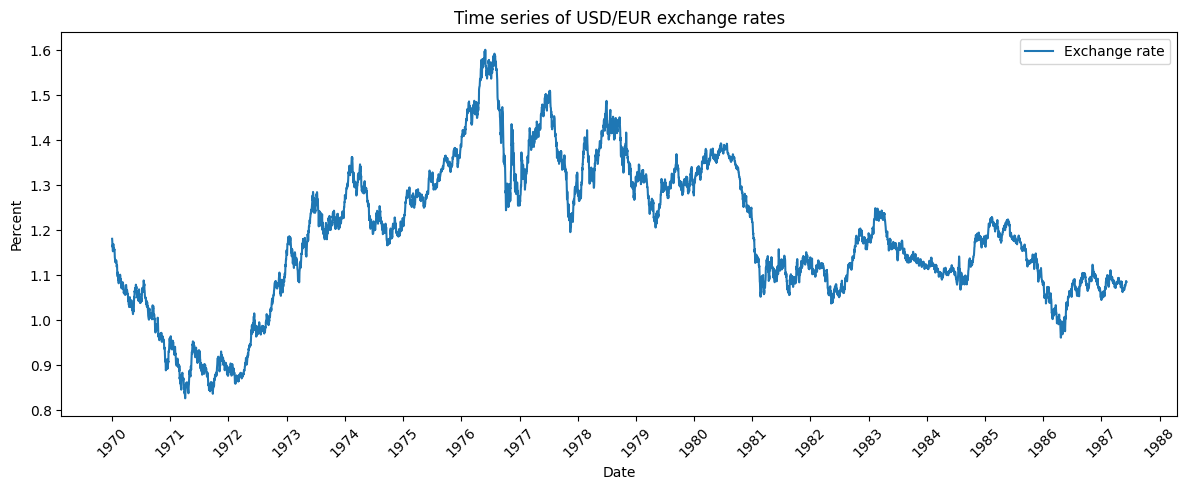

In [33]:
import matplotlib.dates as mdates

figure, ax = plt.subplots(figsize=(12, 5))

ax.plot(date['DATE'], sample_2, label='Exchange rate')

ax.xaxis.set_major_locator(mdates.YearLocator())  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)

plt.title('Time series of USD/EUR exchange rates')
plt.ylabel('Percent')
plt.xlabel('Date')

plt.legend()
plt.tight_layout()
plt.show()


In [34]:
class StochasticProcessSimulator:
    def __init__(self, S0, T, N):
        self.S0 = S0
        self.T = T
        self.N = N
        self.time_line, self.dt = np.linspace(0, T, N, retstep=True)
        self.W = self.generate_wiener_process()
        
    def generate_wiener_process(self):
        W = np.zeros(self.N)
        delta = self.T / self.N
        sqrt_delta = np.sqrt(delta)
        for i in range(1, self.N):
            W[i] = W[i-1] + np.random.normal(0, sqrt_delta)
        return W

    # Constant Elasticity of Variance (CEV) process
    def CEV_process(self, S, kappa, mu, sigma, gamma, dW):
        S_non_neg = np.maximum(S, 1e-6)
        dS = kappa * (mu - S_non_neg) * self.dt + sigma * (S_non_neg**gamma) * dW
        return dS

    # Cox-Ingersoll-Ross (CIR) process
    def CIR_process(self, S, kappa, mu, sigma, dW):
        S_non_neg = np.maximum(S, 1e-6)
        dS = kappa * (mu - S_non_neg) * self.dt + sigma * np.sqrt(S_non_neg) * dW
        return dS

    # Ornstein-Uhlenbeck (OU) process
    def OU_process(self, S, kappa, mu, sigma, dW):
        dS = kappa * (mu - S) * self.dt + sigma * dW
        return dS

    # CKLS process
    def CKLS_process(self, S, kappa, mu, sigma, gamma, dW):
        S_non_neg = np.maximum(S, 1e-6)
        dS = kappa * (mu - S_non_neg) * self.dt + sigma * (S_non_neg**gamma) * dW
        return dS

    def generate_paths(self, parameters):
        paths = {key: np.zeros(self.N) for key in parameters.keys()}
        
        # Initialize starting values
        for key in paths:
            paths[key][0] = self.S0
        
        # Generate paths for each model
        for i in range(1, self.N):
            dW = self.W[i] - self.W[i - 1]
            for key, params in parameters.items():
                if "CEV" in key:
                    paths[key][i] = paths[key][i - 1] + self.CEV_process(paths[key][i - 1], *params, dW)
                elif "CIR" in key:
                    paths[key][i] = paths[key][i - 1] + self.CIR_process(paths[key][i - 1], *params, dW)
                elif "OU" in key:
                    paths[key][i] = paths[key][i - 1] + self.OU_process(paths[key][i - 1], *params, dW)
                elif "CKLS" in key:
                    paths[key][i] = paths[key][i - 1] + self.CKLS_process(paths[key][i - 1], *params, dW)
        
        return paths

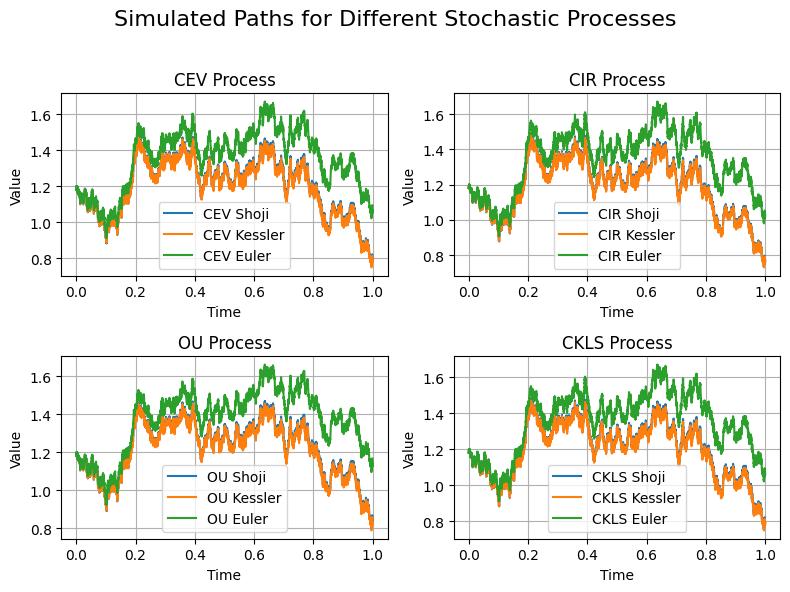

In [35]:
S0 = sample_2[0]
T = 1
N = len(sample_2)
simulator = StochasticProcessSimulator(S0, T, N)

shoji_ozaki_p = [0.01190742, 0.6541825, 0.57703004, 0.32514395]
kessler_p     = [0.02011782, 0.13874663, 0.567096, 0.33594728]
euler_p       = [0.06504598, 5.87897445, 0.57674668, 0.32538039]

parameters = {
    'CEV Shoji': shoji_ozaki_p,
    'CEV Kessler': kessler_p,
    'CEV Euler': euler_p,
    'CIR Shoji': shoji_ozaki_p[:3],
    'CIR Kessler': kessler_p[:3],
    'CIR Euler': euler_p[:3],
    'OU Shoji': shoji_ozaki_p[:3],
    'OU Kessler': kessler_p[:3],
    'OU Euler': euler_p[:3],
    'CKLS Shoji': shoji_ozaki_p,
    'CKLS Kessler': kessler_p,
    'CKLS Euler': euler_p,
}



paths = simulator.generate_paths(parameters)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
fig.suptitle('Simulated Paths for Different Stochastic Processes', fontsize=16)

process_names = ['CEV', 'CIR', 'OU', 'CKLS']
subplots_axes = {process: ax for process, ax in zip(process_names, axes.flatten())}

for process in process_names:
    ax = subplots_axes[process]
    for key, path in paths.items():
        if key.startswith(process):
            ax.plot(simulator.time_line, path, label=key)
    ax.set_title(f'{process} Process')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [36]:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), IGBM(), OrnsteinUhlenbeck(), CKLS()]

param_bounds = [
    [(0.01, 10), (0.01, 2)],                         # Brownian Motion
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # CIR
    [(0.01, 10), (0.01, 2)],                         # GBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # IGBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # OU
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
]

param_guess = [
    [0.01, 0.2],                                     # Brownian Motion
    [0.01, 0.01, 0.01, 0.2],                         # CEV
    [0.01, 0.01, 0.2],                               # CIR
    [0.01, 0.2],                                     # GBM
    [0.01, 0.01, 0.2],                               # IGBM
    [0.01, 0.01, 0.2],                               # OU
    [0.01, 0.01, 0.01, 0.2]                          # CKLS
]


# Initialize the ModelEstimator
estimator = ModelEstimator(sample_2, model, model_name, param_bounds, param_guess)

estimator.fit_models()
estimator.print_aic_bic_results()
estimator.print_best_model()
estimator.print_combined_results()


Initial Params: [0.01, 0.2]
Initial Likelihood: 21003.769729803065
`gtol` termination condition is satisfied.
Number of iterations: 49, function evaluations: 141, CG iterations: 73, optimality: 2.19e-07, constraint violation: 0.00e+00, execution time: 0.11 s.
Final Params: [0.01002983 0.11184463]
Final Likelihood: 22516.39026705843
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -146865.97850677595


C:\Users\Vlada\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1260, CG iterations: 988, optimality: 8.70e+00, constraint violation: 0.00e+00, execution time:  2.1 s.
Final Params: [0.03456095 0.10270907 0.10694656 0.21973395]
Final Likelihood: 22567.15488658152
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 20660.67330453574
`xtol` termination condition is satisfied.
Number of iterations: 176, function evaluations: 720, CG iterations: 416, optimality: 8.51e-03, constraint violation: 0.00e+00, execution time: 0.64 s.
Final Params: [0.23028154 1.17056966 0.10147212]
Final Likelihood: 22617.71824203694
Initial Params: [0.01, 0.2]
Initial Likelihood: 20272.159609299943
`xtol` termination condition is satisfied.
Number of iterations: 125, function evaluations: 384, CG iterations: 227, optimality: 3.54e-03, constraint violation: 0.00e+00, execution time: 0.39 s.
Final Params: [0.01022393 0.0930409 ]
Final Likelihood: 22651.5656344509
Initial 

### Task 3. U.S. Interest Rates.

Fit a time series of IRates over the period  from 06/1964
to 12/1989 (monthly data) by CEV, CIR, OU, CKLS models. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using code from previous labs. *The pymle and other libraries are prohibited.*

The parameter estimates
display in Table for each method. Calculate the AIC and BIC, and select the best model. Compare your results with paper by [Brouste et. al.](https://www.semanticscholar.org/paper/The-YUIMA-Project%3A-A-Computational-Framework-for-of-Brouste-Fukasawa/e9a4696779261dbeca55f316943307d7da5d3d1b) (page 43):

$$dX_t = (2.08 - 0.26 X_t)dt + 0.13 X^{1.44}_t dW_t.$$

Dataset: In order to obtain the data one can open browser, type the address https://rdrr.io/snippets/ and run the code in R language:



```
library(Ecdat)
data(Irates)
rates = Irates[, "r1"]; rates
plot(rates)
```



In [39]:
date = pd.read_excel('C://Users//Vlada//Desktop//Sirius//statistics_of_random_processes//Task_3.xlsx', index_col = 0)
df = np.array(date)

In [40]:
df

array([[   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,  0.325],
       [ 0.322,  0.326,  0.318,  0.302,  0.288,  0.328,  0.378,  0.528,
         0.742,  0.732,  0.814,  0.904],
       [ 0.959,  0.968,  0.978,  0.984,  0.987,  0.975,  0.992,  1.063,
         1.082,  1.084,  1.101,  1.11 ],
       [ 1.126,  1.139,  1.114,  1.123,  1.092,  1.016,  0.96 ,  0.982,
         1.01 ,  0.985,  1.011,  1.035],
       [ 1.072,  1.1  ,  1.084,  1.112,  1.136,  1.129,  1.158,  1.246,
         1.291,  1.184,  1.307,  1.25 ],
       [ 1.209,  1.21 ,  1.439,  1.329,  1.344,  1.382,  1.491,  1.538,
         1.596,  1.258,  1.388,  1.696],
       [ 1.332,  1.342,  1.374,  1.579,  1.642,  1.747,  1.802,  1.712,
         1.459,  1.589,  1.781,  1.941],
       [ 1.819,  2.019,  1.987,  2.062,  1.935,  1.606,  1.936,  1.79 ,
         1.22 ,  0.975,  1.439,  1.248],
       [ 0.958,  0.887,  0.985,  0.673,  0.603,  0.62 ,  0.679,  1.107,
         0.903,  0.845, 

In [41]:
data = da.flatten()
df = pd.DataFrame(data)
df = df.dropna()

df.columns = ['IRates']
date_range = pd.date_range(start="1946-12-01", end="1991-02-01", freq="MS")
df['date']= date_range
df['date']== df['date'].dt.strftime('%Y-%m')
# date_range
df

,IRates,date
11,0.325,1946-12-01
12,0.322,1947-01-01
13,0.326,1947-02-01
14,0.318,1947-03-01
15,0.302,1947-04-01
...,...,...
537,6.709,1990-10-01
538,6.659,1990-11-01
539,5.867,1990-12-01
540,5.953,1991-01-01


In [42]:
df.max()

IRates                  16.21
date      1991-02-01 00:00:00
dtype: object

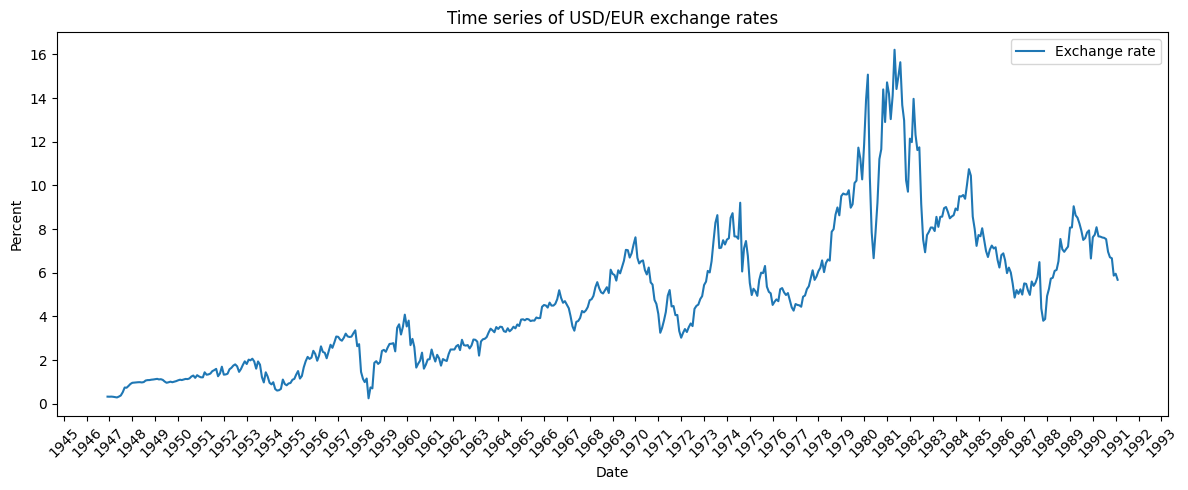

In [43]:
figure, ax = plt.subplots(figsize=(12, 5))

ax.plot(df['date'], df['IRates'], label='Exchange rate')

ax.xaxis.set_major_locator(mdates.YearLocator())  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)

plt.title('Time series of USD/EUR exchange rates')
plt.ylabel('Percent')
plt.xlabel('Date')

plt.legend()
plt.tight_layout()
plt.show()


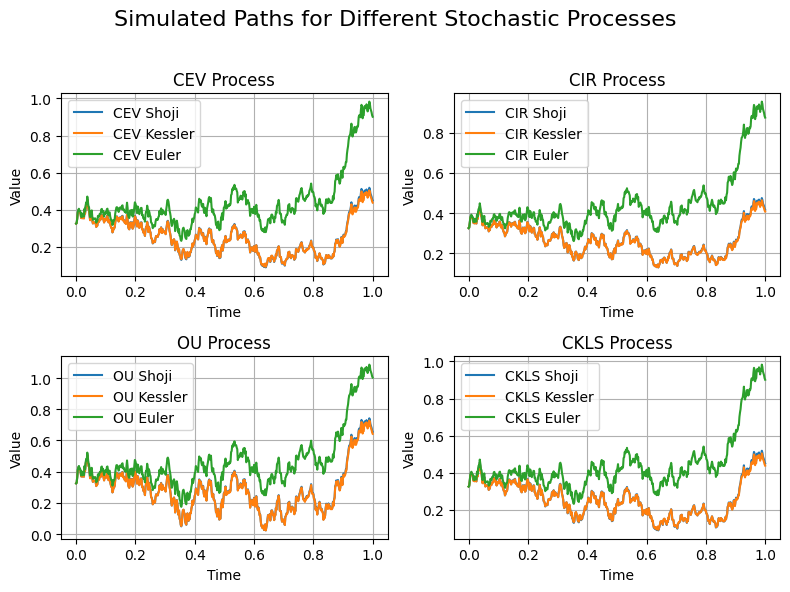

In [44]:
sample_3 = np.array(df['IRates'])
S0 = sample_3[0]
T = 1
N = len(sample_3)
simulator = StochasticProcessSimulator(S0, T, N)

shoji_ozaki_p = [0.01190742, 0.6541825, 0.57703004, 0.32514395]
kessler_p     = [0.02011782, 0.13874663, 0.567096, 0.33594728]
euler_p       = [0.06504598, 5.87897445, 0.57674668, 0.32538039]

parameters = {
    'CEV Shoji': shoji_ozaki_p,
    'CEV Kessler': kessler_p,
    'CEV Euler': euler_p,
    'CIR Shoji': shoji_ozaki_p[:3],
    'CIR Kessler': kessler_p[:3],
    'CIR Euler': euler_p[:3],
    'OU Shoji': shoji_ozaki_p[:3],
    'OU Kessler': kessler_p[:3],
    'OU Euler': euler_p[:3],
    'CKLS Shoji': shoji_ozaki_p,
    'CKLS Kessler': kessler_p,
    'CKLS Euler': euler_p,
}



paths = simulator.generate_paths(parameters)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
fig.suptitle('Simulated Paths for Different Stochastic Processes', fontsize=16)

process_names = ['CEV', 'CIR', 'OU', 'CKLS']
subplots_axes = {process: ax for process, ax in zip(process_names, axes.flatten())}

for process in process_names:
    ax = subplots_axes[process]
    for key, path in paths.items():
        if key.startswith(process):
            ax.plot(simulator.time_line, path, label=key)
    ax.set_title(f'{process} Process')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [45]:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), IGBM(), OrnsteinUhlenbeck(), CKLS()]

param_bounds = [
    [(0.01, 10), (0.01, 2)],                         # Brownian Motion
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # CIR
    [(0.01, 10), (0.01, 2)],                         # GBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # IGBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # OU
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
]

param_guess = [
    [0.01, 0.2],                                     # Brownian Motion
    [0.01, 0.01, 0.01, 0.2],                         # CEV
    [0.01, 0.01, 0.2],                               # CIR
    [0.01, 0.2],                                     # GBM
    [0.01, 0.01, 0.2],                               # IGBM
    [0.01, 0.01, 0.2],                               # OU
    [0.01, 0.01, 0.01, 0.2]                          # CKLS
]


# Initialize the ModelEstimator
estimator = ModelEstimator(sample_3, model, model_name, param_bounds, param_guess)

estimator.fit_models()
estimator.print_aic_bic_results()
estimator.print_best_model()
estimator.print_combined_results()


Initial Params: [0.01, 0.2]
Initial Likelihood: -24674.766899043825
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 102, CG iterations: 42, optimality: 8.55e-04, constraint violation: 0.00e+00, execution time: 0.063 s.
Final Params: [8.29542793 1.99999964]
Final Likelihood: -3404.746026668633
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35672.5169125899
`xtol` termination condition is satisfied.
Number of iterations: 37, function evaluations: 205, CG iterations: 98, optimality: 1.69e+02, constraint violation: 0.00e+00, execution time: 0.074 s.
Final Params: [0.65585893 0.7398841  2.29050535 0.71287424]
Final Likelihood: -376.566706227482
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -18252.900715605694


C:\Users\Vlada\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 63, function evaluations: 264, CG iterations: 120, optimality: 5.50e-02, constraint violation: 0.00e+00, execution time: 0.11 s.
Final Params: [3.61131931 6.03311456 1.99518302]
Final Likelihood: -645.2128876984586
Initial Params: [0.01, 0.2]
Initial Likelihood: -10138.910068519162
`xtol` termination condition is satisfied.
Number of iterations: 23, function evaluations: 39, CG iterations: 24, optimality: 3.71e+02, constraint violation: 0.00e+00, execution time: 0.016 s.
Final Params: [0.48717187 1.09611534]
Final Likelihood: -630.1120355624482
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -10141.342155818053
`xtol` termination condition is satisfied.
Number of iterations: 57, function evaluations: 240, CG iterations: 107, optimality: 7.49e-05, constraint violation: 0.00e+00, execution time: 0.097 s.
Final Params: [1.4488632  6.56255405 1.7438958 ]
Final Likelihood: -435.2163924479879
Initial Params: [0.01, 0.01, 

#### Task 4.

Take a dual-listed security (for instance, Apple, Google, Amazon), which trade simultaneously on two exchanges. Fit a time series of spread over the 5 years period (day data) by CEV, CIR, OU, CKLS models.

For example, one can use the paper by [Bertram, 2009](https://https://www.sciencedirect.com/science/article/pii/S0378437109002829)
where a spread constructed on the dual-listed security, ANZ Bank (ANZ). Calculate the AIC and BIC, and select the best model.

Hint. Use refs for selection a dual-listed security. Calculate the AIC and BIC, and select the best model.

https://live.euronext.com/en/product/equities/US0378331005-MTAH

https://stockanalysis.com/list/indian-stocks-us/

In [46]:
import yfinance as yf

In [47]:
start_date = "2018-01-01"
end_date = "2023-01-01"

goog_nasdaq = yf.download("GOOG", start=start_date, end=end_date)
goog_nasdaq = goog_nasdaq['Close'].rename('Price_NASDAQ')

goog_mexico = yf.download("GOOG.MX", start=start_date, end=end_date)
goog_mexico = goog_mexico['Close'].rename('Price_Mexico')

# fetch USD/MXN exchange rate data
usd_mxn = yf.download("USDMXN=X", start=start_date, end=end_date)
usd_mxn = usd_mxn['Close'].rename('USD_MXN')

data = pd.concat([goog_nasdaq, goog_mexico, usd_mxn], axis=1)
data.dropna(inplace=True)
data['Price_MXN_USD'] = data['Price_Mexico'] / data['USD_MXN']
data['Spread'] = data['Price_NASDAQ'] - data['Price_MXN_USD']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


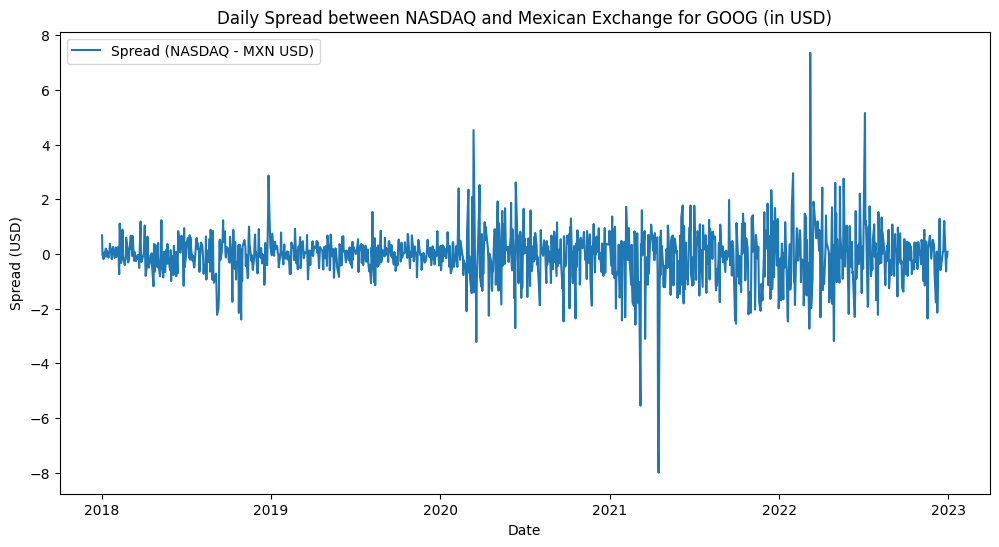

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(data['Spread'], label="Spread (NASDAQ - MXN USD)")
plt.title("Daily Spread between NASDAQ and Mexican Exchange for GOOG (in USD)")
plt.xlabel("Date")
plt.ylabel("Spread (USD)")
plt.legend()
plt.show()

In [49]:
data.head()

,Price_NASDAQ,Price_Mexico,USD_MXN,Price_MXN_USD,Spread
Date,,,,,
2018-01-02,53.250000,1025.000000,19.497400,52.571111,0.678889
2018-01-03,54.124001,1048.469971,19.351101,54.181412,-0.057411
2018-01-04,54.320000,1049.400024,19.306971,54.353427,-0.033428
2018-01-05,55.111500,1060.406006,19.174000,55.304371,-0.192872
2018-01-08,55.347000,1060.835449,19.192120,55.274533,0.072467


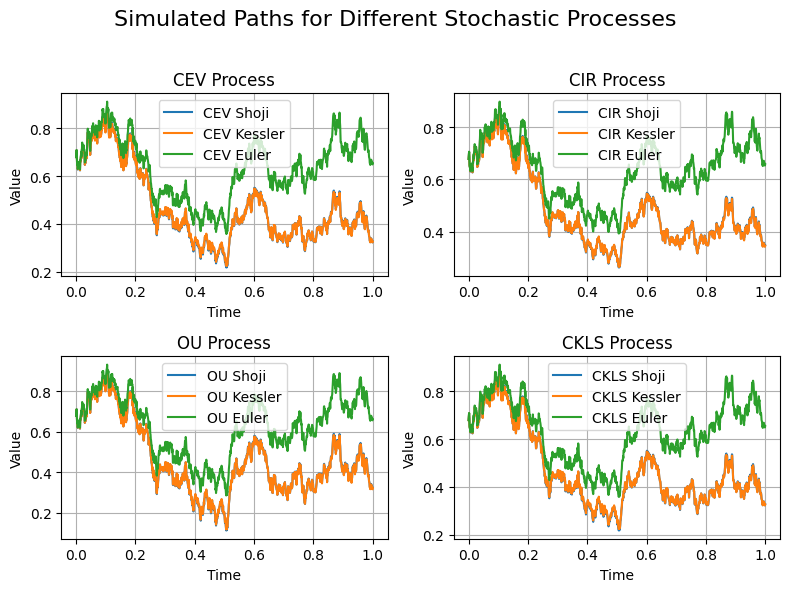

In [50]:
sample_4 = np.array(data['Spread'])
S0 = sample_4[0]
T = 1
N = len(sample_4)
simulator = StochasticProcessSimulator(S0, T, N)

shoji_ozaki_p = [0.01190742, 0.6541825, 0.57703004, 0.32514395]
kessler_p     = [0.02011782, 0.13874663, 0.567096, 0.33594728]
euler_p       = [0.06504598, 5.87897445, 0.57674668, 0.32538039]

parameters = {
    'CEV Shoji': shoji_ozaki_p,
    'CEV Kessler': kessler_p,
    'CEV Euler': euler_p,
    'CIR Shoji': shoji_ozaki_p[:3],
    'CIR Kessler': kessler_p[:3],
    'CIR Euler': euler_p[:3],
    'OU Shoji': shoji_ozaki_p[:3],
    'OU Kessler': kessler_p[:3],
    'OU Euler': euler_p[:3],
    'CKLS Shoji': shoji_ozaki_p,
    'CKLS Kessler': kessler_p,
    'CKLS Euler': euler_p,
}



paths = simulator.generate_paths(parameters)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
fig.suptitle('Simulated Paths for Different Stochastic Processes', fontsize=16)

process_names = ['CEV', 'CIR', 'OU', 'CKLS']
subplots_axes = {process: ax for process, ax in zip(process_names, axes.flatten())}

for process in process_names:
    ax = subplots_axes[process]
    for key, path in paths.items():
        if key.startswith(process):
            ax.plot(simulator.time_line, path, label=key)
    ax.set_title(f'{process} Process')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [51]:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), IGBM(), OrnsteinUhlenbeck(), CKLS()]

param_bounds = [
    [(0.01, 10), (0.01, 2)],                         # Brownian Motion
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # CIR
    [(0.01, 10), (0.01, 2)],                         # GBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # IGBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # OU
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
]

param_guess = [
    [0.01, 0.2],                                     # Brownian Motion
    [0.01, 0.01, 0.01, 0.2],                         # CEV
    [0.01, 0.01, 0.2],                               # CIR
    [0.01, 0.2],                                     # GBM
    [0.01, 0.01, 0.2],                               # IGBM
    [0.01, 0.01, 0.2],                               # OU
    [0.01, 0.01, 0.01, 0.2]                          # CKLS
]


# Initialize the ModelEstimator
estimator = ModelEstimator(sample_4, model, model_name, param_bounds, param_guess)

estimator.fit_models()
estimator.print_aic_bic_results()
estimator.print_best_model()
estimator.print_combined_results()


Initial Params: [0.01, 0.2]
Initial Likelihood: -74996.64060524241
`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 30, CG iterations: 13, optimality: 4.10e-07, constraint violation: 0.00e+00, execution time: 0.026 s.
Final Params: [0.01017402 1.99999926]
Final Likelihood: -28555.82345848324
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: nan


C:\Users\Vlada\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymle\models\CEV.py:31: RuntimeWarning: invalid value encountered in power
  return self._params[2] * x ** self._params[3]
C:\Users\Vlada\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymle\models\CIR.py:33: RuntimeWarning: invalid value encountered in sqrt
  return self._params[2] * np.sqrt(x)


The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 10, CG iterations: 996, optimality: nan, constraint violation: 0.00e+00, execution time: 0.18 s.
Final Params: [0.01 0.01 0.01 0.2 ]
Final Likelihood: nan
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: nan
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 8, CG iterations: 747, optimality: nan, constraint violation: 0.00e+00, execution time: 0.15 s.
Final Params: [0.01 0.01 0.2 ]
Final Likelihood: nan
Initial Params: [0.01, 0.2]
Initial Likelihood: -81191.18198131793
`gtol` termination condition is satisfied.
Number of iterations: 9, function evaluations: 24, CG iterations: 12, optimality: 5.02e-07, constraint violation: 0.00e+00, execution time: 0.0032 s.
Final Params: [0.01146133 1.99999333]
Final Likelihood: -53681.18915598131
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -81190.88598193294
`gtol` termination c

C:\Users\Vlada\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymle\models\CKLS.py:26: RuntimeWarning: invalid value encountered in power
  return self._params[2] * x ** self._params[3]


The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 10, CG iterations: 996, optimality: nan, constraint violation: 0.00e+00, execution time:  0.2 s.
Final Params: [0.01 0.01 0.01 0.2 ]
Final Likelihood: nan
Initial Params: [0.01, 0.2]
Initial Likelihood: -74996.64060524222
`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 30, CG iterations: 13, optimality: 4.11e-07, constraint violation: 0.00e+00, execution time: 0.021 s.
Final Params: [0.01017463 1.99999926]
Final Likelihood: -28555.823461771142
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: nan
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 10, CG iterations: 996, optimality: nan, constraint violation: 0.00e+00, execution time: 0.21 s.
Final Params: [0.01 0.01 0.01 0.2 ]
Final Likelihood: nan
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: nan
The maximum number of 

C:\Users\Vlada\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 36, function evaluations: 168, CG iterations: 48, optimality: 1.13e-03, constraint violation: 0.00e+00, execution time: 0.067 s.
Final Params: [9.98295428 0.01000252 1.99999893]
Final Likelihood: -68711.34650684742
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -74996.42271878528
`gtol` termination condition is satisfied.
Number of iterations: 36, function evaluations: 128, CG iterations: 51, optimality: 5.62e-08, constraint violation: 0.00e+00, execution time: 0.071 s.
Final Params: [0.01027916 0.01042305 1.99999998]
Final Likelihood: -28555.72921030938
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: nan
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 10, CG iterations: 996, optimality: nan, constraint violation: 0.00e+00, execution time:  0.2 s.
Final Params: [0.01 0.01 0.01 0.2 ]
Final Likelihood: nan
Initial Params: [0.01, 0.2]
Initial Likelih